MODEL HALAL STOCK

In [47]:
from cassandra.cluster import Cluster
import pandas as pd
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

Connect to Data base for import Data

In [23]:
cluster = Cluster(['127.0.0.1'])
session = cluster.connect('info_stock')

In [24]:
rows = session.execute('SELECT * FROM financial_data')
df = pd.DataFrame(rows.all())

In [25]:
df.head(3)

,ticker,industry,interest_income,long_business_summary,name,sector,total_assets,total_debt,total_revenue
0,SIAM.BK,"Furnishings, Fixtures & Appliances",-0.02879,Siam Steel International Public Company Limite...,SIAM_SIAM STEEL INTERNATIONAL,Consumer Cyclical,1.0,2.040780e+08,1.773048e+09
1,KAMART.BK,Household & Personal Products,0.27538,"Karmarts Public Company Limited, together with...",KAMART_KARMARTS,Consumer Defensive,1.0,6.533160e+08,3.322751e+09
2,IFS.BK,Credit Services,0.40719,IFS Capital (Thailand) Public Company Limited ...,IFS_IFS CAPITAL (THAILAND),Financial Services,1.0,2.237478e+09,4.514385e+08


In [26]:
df.shape

(921, 9)

In [27]:
df.columns

Index(['ticker', 'industry', 'interest_income', 'long_business_summary',
       'name', 'sector', 'total_assets', 'total_debt', 'total_revenue'],
      dtype='object')

In [36]:
df = df.drop(columns=['interest_income','total_assets', 'total_debt', 'total_revenue'])

Vocab about haram

In [37]:
# ✅ Vocab ที่คุณให้ไว้
vocab = {
    "Interest": {
        "Finance": [
            "interest rate", "compound interest", "loan", "mortgage", "investment"
        ],
        "Emotion": [
            "curiosity", "fascination", "passion", "hobby", "engagement"
        ]
    },
    "Gambling": [
        "bet", "wager", "casino", "odds", "jackpot", "addiction",
        "high roller", "roulette", "poker", "blackjack", "slot machine"
    ],
    "Pigs": [
        "piglet", "sow", "boar", "snout", "trough", "oink", "sty", "swine"
    ],
    "Music": [
        "melody", "harmony", "rhythm", "genre", "instrument", "lyrics",
        "composer", "band", "orchestra", "choir"
    ],
    "Prostitution": [
        "sex work", "sex worker", "brothel", "escort", "solicit", "pimp",
        "client", "john", "red-light district"
    ]
}

In [38]:

def contains_haram_keywords(text, vocab):
    text = text.lower()
    for items in vocab.values():
        if isinstance(items, dict):
            for sublist in items.values():
                if any(word in text for word in sublist):
                    return True
        else:
            if any(word in text for word in items):
                return True
    return False


In [40]:

df['has_haram_vocab'] = df['long_business_summary'].apply(lambda x: contains_haram_keywords(x, vocab))


In [41]:

class NumericFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        return np.array(X).reshape(-1, 1)


In [42]:

features = ['long_business_summary', 'has_haram_vocab']
X = df[features]
y = df['halal_status']

preprocessor = ColumnTransformer([
    ('summary_tfidf', TfidfVectorizer(), 'long_business_summary'),
    ('haram_flag', NumericFeatureExtractor(), 'has_haram_vocab'),
    
])

model = make_pipeline(preprocessor, LogisticRegression())
model.fit(X, y)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('summary_tfidf',
                                                  TfidfVectorizer(),
                                                  'long_business_summary'),
                                                 ('haram_flag',
                                                  NumericFeatureExtractor(),
                                                  'has_haram_vocab')])),
                ('logisticregression', LogisticRegression())])

In [43]:

y_pred = model.predict(X)
print(classification_report(y, y_pred))


              precision    recall  f1-score   support

       halal       1.00      0.03      0.06       133
       haram       0.86      1.00      0.92       788

    accuracy                           0.86       921
   macro avg       0.93      0.52      0.49       921
weighted avg       0.88      0.86      0.80       921



In [44]:
df.head(10)

,ticker,industry,long_business_summary,name,sector,has_haram_vocab,halal_status
0,SIAM.BK,"Furnishings, Fixtures & Appliances",Siam Steel International Public Company Limite...,SIAM_SIAM STEEL INTERNATIONAL,Consumer Cyclical,False,halal
1,KAMART.BK,Household & Personal Products,"Karmarts Public Company Limited, together with...",KAMART_KARMARTS,Consumer Defensive,True,haram
2,IFS.BK,Credit Services,IFS Capital (Thailand) Public Company Limited ...,IFS_IFS CAPITAL (THAILAND),Financial Services,False,haram
3,POPF.BK,,Prime Office Leasehold Property Fund specializ...,POPF_PRIME OFFICE LEASEHOLD,,True,haram
4,PYLON.BK,Engineering & Construction,"Pylon Public Company Limited, together with it...",PYLON_PYLON,Industrials,False,haram
5,SYMC.BK,Telecom Services,Symphony Communication Public Company Limited ...,SYMC_SYMPHONY COMMUNICATION,Communication Services,True,haram
6,WHAIR.BK,REIT - Industrial,,WHAIR_WHA INDUSTRIAL LEASEHOLD,Real Estate,False,halal
7,THG.BK,Medical Care Facilities,Thonburi Healthcare Group Public Company Limit...,THG_THONBURI HEALTHCARE GROUP,Healthcare,False,haram
8,DCON.BK,Building Materials,"Dcon Products Public Company Limited, together...",DCON_DCON PRODUCTS,Basic Materials,False,haram
9,TAN.BK,Luxury Goods,Tanachira Retail Corporation Public Company Li...,TAN_TANACHIRA RETAIL CORPORATIO,Consumer Cyclical,True,haram


C:\Users\Admin\AppData\Local\Temp\ipykernel_4312\2275665500.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='halal_status', palette='Set2')


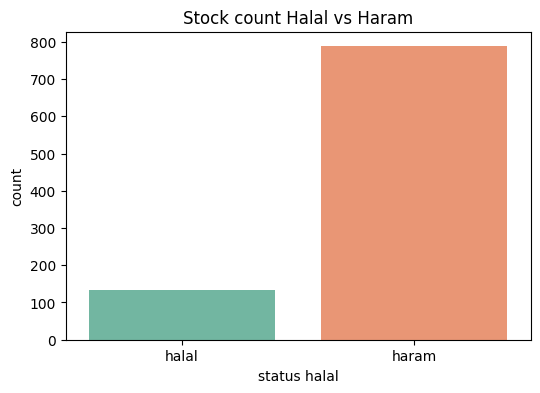

In [49]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='halal_status', palette='Set2')
plt.title('Stock count Halal vs Haram')
plt.xlabel('status halal')
plt.ylabel('count')
plt.show()

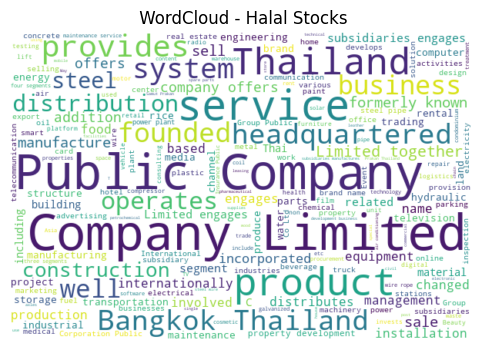

In [53]:
halal_text = ' '.join(df[df['halal_status'] == 'halal']['long_business_summary'].astype(str))
haram_text = ' '.join(df[df['halal_status'] == 'haram']['long_business_summary'].astype(str))
wc_halal = WordCloud(background_color='white', width=600, height=400).generate(halal_text)
plt.figure(figsize=(6,4))
plt.imshow(wc_halal, interpolation='bilinear')
plt.axis('off')
plt.title(' WordCloud - Halal Stocks')
plt.show()

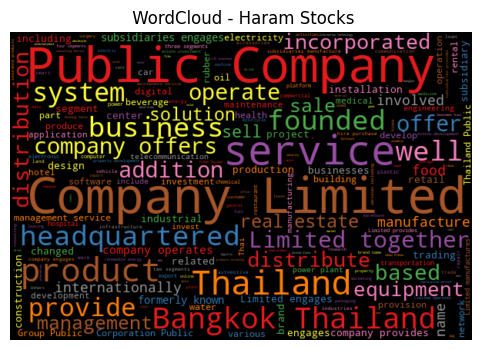

In [55]:
wc_haram = WordCloud(background_color='black', colormap='Set1', width=600, height=400).generate(haram_text)
plt.figure(figsize=(6,4))
plt.imshow(wc_haram, interpolation='bilinear')
plt.axis('off')
plt.title(' WordCloud - Haram Stocks')
plt.show()

In [56]:
import yfinance as yf
import pandas as pd

# ✅ ฟังก์ชันตรวจคำฮารอม
def contains_haram_keywords(text, vocab):
    text = text.lower()
    for items in vocab.values():
        if isinstance(items, dict):
            for sublist in items.values():
                if any(word in text for word in sublist):
                    return True
        else:
            if any(word in text for word in items):
                return True
    return False

# ✅ ฟังก์ชันหลัก: ป้อนชื่อหุ้น → ตรวจ halal/haram
def check_halal_by_ticker(ticker, vocab, model, debt_ratio=0.0):
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        summary = info.get("longBusinessSummary", "")

        if not summary:
            return f"⚠️ ไม่พบข้อมูล business summary สำหรับ '{ticker}'"

        has_haram = contains_haram_keywords(summary, vocab)

        input_df = pd.DataFrame([{
            'long_business_summary': summary,
            'has_haram_vocab': has_haram,
            'debt_ratio': debt_ratio
        }])

        result = model.predict(input_df)[0]
        return f"✅ หุ้น '{ticker}' เป็น: '{result.upper()}'"

    except Exception as e:
        return f"❌ เกิดข้อผิดพลาด: {e}"


In [60]:
# ต้องแน่ใจว่า model และ vocab ถูกโหลดไว้แล้วก่อนใช้งาน
print(check_halal_by_ticker("WHAIR.BK", vocab, model))     # หุ้น Apple

⚠️ ไม่พบข้อมูล business summary สำหรับ 'WHAIR.BK'
